# KAN Intro

We will use example provided in the official implementation of the KAN paper.
Install the library with

```pip install pykan```

**Function Fitting**

We will take [Example-1](https://github.com/KindXiaoming/pykan/blob/master/tutorials/Example/Example_1_function_fitting.ipynb) provided in the PyKAN repo.

The function is 
$$
f(x) = \sin(\pi x_1) + x_2^2 \\
x_1, x_2 \sim U[-1,1]
$$


In [1]:
import torch
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is: ',device)

from kan.utils import create_dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)

print('train input data shape', dataset['train_input'].shape)
print('train label data shape', dataset['train_label'].shape)

device is:  cpu
train input data shape torch.Size([1000, 2])
train label data shape torch.Size([1000, 1])


In [2]:
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
from kan import KAN
model = KAN(width=[2,5,1], grid=3, k=3, seed=42, device=device)

checkpoint directory created: ./model
saving model version 0.0


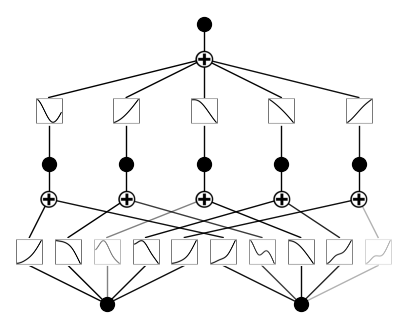

In [3]:
# plot KAN at initialization
model(dataset['train_input']);
model.plot()

In [4]:
# train the model
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);

| train_loss: 1.88e-02 | test_loss: 1.78e-02 | reg: 6.80e+00 | : 100%|█| 50/50 [00:13<00:00,  3.79it

saving model version 0.1


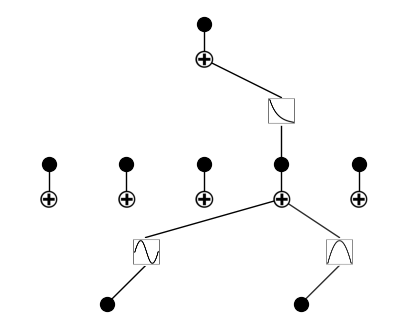

In [5]:
# visualise the trained model
model.plot()

saving model version 0.2


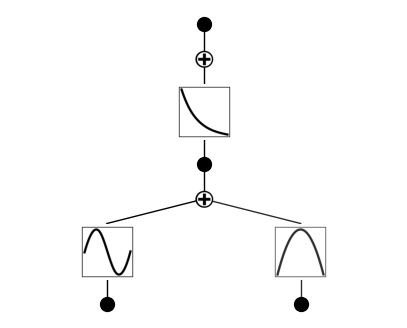

In [6]:
# prune the model, and revisualize
model = model.prune()
model.plot()

In [7]:
# contnue retraining based on the pruned model
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 1.79e-02 | test_loss: 1.72e-02 | reg: 7.66e+00 | : 100%|█| 50/50 [00:03<00:00, 13.81it

saving model version 0.3


In [8]:
mode = "auto" # "manual"

if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9998313640557426, c=2
fixing (0,1,0) with x^2, r2=0.9999907195889106, c=2
fixing (1,0,0) with exp, r2=0.9999810964976568, c=2
saving model version 0.4


In [9]:
# continue retrained and fit the symbolic functions that were found earlier
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 9.43e-12 | test_loss: 5.75e-12 | reg: 0.00e+00 | : 100%|█| 50/50 [00:01<00:00, 27.50it

saving model version 0.5


In [10]:
# plot the symbolic model
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0],4)

1.0*exp(1.0*x_2**2 + 1.0*sin(3.1416*x_1))

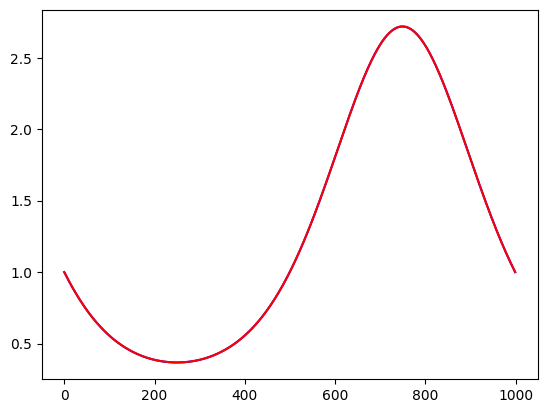

In [12]:
X = dataset['train_input']
n  = 1000
X[:,0] = torch.linspace(-1,1,steps=n)
X[:,1] = torch.zeros(n)
y = f(X)
y = y[:,0].detach().numpy()
yh = model.forward(X)

yh = yh[:,0].detach().numpy()
plt.plot(y,color='blue')
plt.plot(yh, color='red')

(-1.0, 1.0)

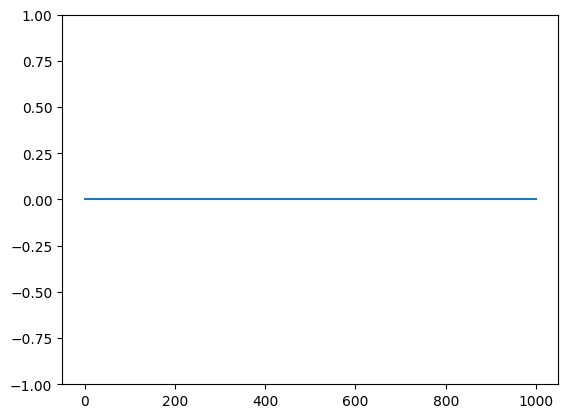

In [13]:
plt.plot(y-yh)
plt.ylim(-1,1)

Indeed, the correct function was recovered, exactly. This would have been very hard for an MLP. Let us how a off-the-shelf (meaning no tuning) MLP will work out of the box. We will copy an MLP from this [regression](./00-01-FFN-Regression-Friendman2.ipynb) notebook.

In [14]:
import torch.nn as nn

# define the model.
# the model is exactly the same as the model we saw in earlier
class MLP(nn.Module):
    # define nn
    def __init__(self, input_dim=4, output_dim=3, hidden_dim = [128,64]):
        super(MLP, self).__init__()
        self.input = nn.Linear(input_dim, hidden_dim[0])
        self.hidden = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.out = nn.Linear(hidden_dim[1], output_dim)
        self.relu = nn.ReLU()
        self.silu = nn.SiLU()

    def forward(self, X):
        X = self.silu(self.input(X))
        X = self.silu(self.hidden(X))
        X = self.out(X)
        return X

In [15]:
input_dim = 2
output_dim = 1
hidden_dim = [64, 64]
mlp = MLP(input_dim=input_dim, output_dim=output_dim, hidden_dim=hidden_dim)

learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(),lr=learning_rate)

In [16]:
def train_network(model,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses):
    for epoch in range(num_epochs):
        #clear out the gradients from the last step loss.backward()
        model.train()
        optimizer.zero_grad()
        
        #forward feed
        output_train = model(X_train)

        #calculate the loss
        loss_train = criterion(output_train, y_train)


        #backward propagation: calculate gradients
        loss_train.backward()

        #update the weights
        optimizer.step()
        
        model.eval()
        output_test = model(X_test)
        loss_test = criterion(output_test,y_test)

        train_losses[epoch] = loss_train.item()
        test_losses[epoch] = loss_test.item()

        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss_train.item():.4f}, Test Loss: {loss_test.item():.4f}")
    return model, train_losses, test_losses



import numpy as np
num_epochs = 1000
train_losses = np.zeros(num_epochs)
test_losses  = np.zeros(num_epochs)
X_train = dataset['train_input']
y_train = dataset['train_label']
X_test = dataset['test_input']
y_test = dataset['test_label']
mlp, train_losses, test_losses = train_network(mlp,optimizer,criterion,X_train,y_train,X_test,y_test,num_epochs,train_losses,test_losses)

Epoch 50/1000, Train Loss: 2.0488, Test Loss: 1.8635
Epoch 100/1000, Train Loss: 2.0481, Test Loss: 1.8814
Epoch 150/1000, Train Loss: 2.0478, Test Loss: 1.8812
Epoch 200/1000, Train Loss: 2.0476, Test Loss: 1.8800
Epoch 250/1000, Train Loss: 2.0474, Test Loss: 1.8780
Epoch 300/1000, Train Loss: 2.0468, Test Loss: 1.8737
Epoch 350/1000, Train Loss: 2.0453, Test Loss: 1.8607
Epoch 400/1000, Train Loss: 2.0437, Test Loss: 1.8382
Epoch 450/1000, Train Loss: 2.0425, Test Loss: 1.8111
Epoch 500/1000, Train Loss: 2.0418, Test Loss: 1.7928
Epoch 550/1000, Train Loss: 2.0415, Test Loss: 1.7889
Epoch 600/1000, Train Loss: 2.0413, Test Loss: 1.7895
Epoch 650/1000, Train Loss: 2.0411, Test Loss: 1.7912
Epoch 700/1000, Train Loss: 2.0411, Test Loss: 1.7929
Epoch 750/1000, Train Loss: 2.0410, Test Loss: 1.7938
Epoch 800/1000, Train Loss: 2.0410, Test Loss: 1.7942
Epoch 850/1000, Train Loss: 2.0409, Test Loss: 1.7945
Epoch 900/1000, Train Loss: 2.0408, Test Loss: 1.7956
Epoch 950/1000, Train Loss: 2

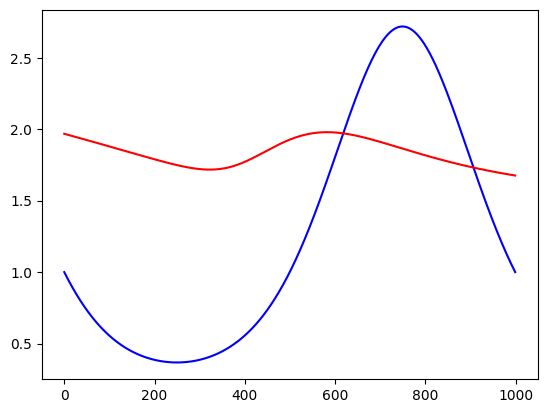

In [17]:
n = len(X_train)
X[:,0] = torch.linspace(-1,1,steps=n)
X[:,1] = torch.zeros(n)
y = f(X)
y = y[:,0].detach().numpy()
yh = mlp(X)

yh = yh[:,0].detach().numpy()
plt.plot(y,color='blue')
plt.plot(yh, color='red')

The MLP has hard time learning this function. Architectures search and tuning hyperparams is needed. 